## Impulse Response Measurements with Sine Sweeps

Measuring impulse responses is a frequent task in acoustics. Room impulse responses are often used to compute room acoustic parameters and loudspeaker impulse responses often serve as a basis for designing equalization filters to name only two examples. The impulse response $h[n]$ relates any input or excitation signal $x[n]$ of a system (e.g. a room or loudspeaker) to the output $y[n]$ that can be recorded with a microphone. Formally this link is given by the convolution

$$y[n] = h[n] \ast x[n]\,.$$

The following sections will give an example of an impulse response measurement with an exponential sine sweep and a brief introduction of the related theory. For more background information see for example:

Müller, S., & Massarani, P. (2001). Transfer function measurement with Sweeps. Directors cut including previously unreleased material and some corrections. *J. Audio Eng. Soc.* (Original Release), 49(6), 443–471.

Before continuing with this example it is helpful to go through the `LINK-TO-SIGNALS-EXAMPLE` and `LINK-TO-ARITHMETICS`.


In [1]:
import pyfar as pf
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt
import os
%matplotlib inline

### Excitation signal

Theoretically any signal can be used for excitation, however there are a few requirements that should be considered for acoustical measurements. The excitation signals should

- be broad band, that is, it should cover the frequency range of interest for example the range of human hearing starting at 20 Hz and going up to 20 kHz
- contain enough energy to achieve a sufficient signal-to-noise ratio in the measured impulse response
- be robust to acoustic noise
- robust to harmonic distortion that can appear due to non-ideal sound sources (loudspeakers)

Sine sweeps are sine signals with a continuously changing frequency that satisfy all these conditions. They are thus the predominant excitation signal for acoustical measurements. Their band width can be freely chosen and their energy can be adjusted by changing the length of the sweep signal.

This example uses an exponential sine sweep designed in the time domain. For illustration purposes, the bandwidth is restricted between 50 Hz and 16 kHz. The sweep can be generated with the [`pyfar.signals`](https://pyfar.readthedocs.io/en/stable/modules/pyfar.signals.html) module

In [2]:
x = pf.signals.exponential_sweep_time(
    n_samples=2**16,
    frequency_range=[50, 22050],
    sampling_rate=44100)

and plotted with the [`pyfar.plot`](https://pyfar.readthedocs.io/en/stable/modules/pyfar.plot.html) module

Text(0.5, 1.0, 'Exponential sweep excitation signal')

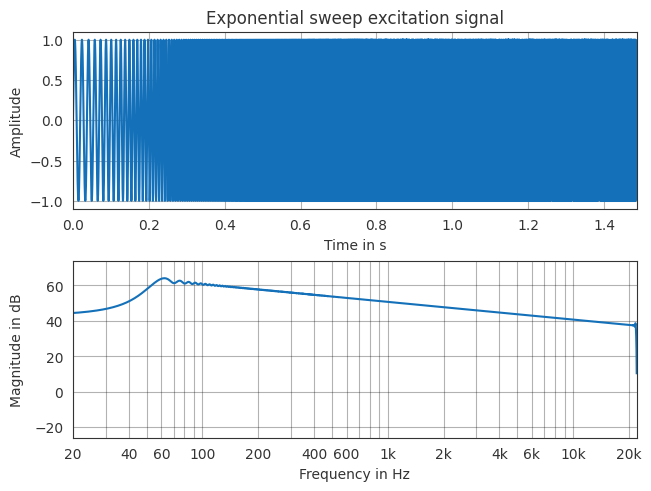

In [3]:
ax = pf.plot.time_freq(x)
ax[0].set_title('Exponential sweep excitation signal')

Listening to the sweep using the `sounddevice` package makes it clear that this is indeed a sine signal with changing frequency.

**Note: Watch your output level before continuing!**

In [4]:
# listen using default output device
sd.play(x.time.T, x.sampling_rate, blocking=True)

### Recording the System Response

![Measurement Setup](../../resources/impulse_response_measurement.png)

The system response can be obtained by playing the sweep through a loudspeaker and recording it with a microphone. In the image above, this refers to the upper signal path. In many cases, it is desired to compensate/remove the influence of the measurement chain, for example the sound card. To do so, we also record the signal by directly looping the output of the sound card to the input. This is the lower signal path in the image above.

At last, the order of the system has to be considered, that is, the sweep signal should be padded with zeros to allow the system response to decay. In this example, we measure a room impulse response. A conservative option is to pad zeros according to the expected reverberation time, we padd one seconds of zeros in this case.

In [5]:
x_padded = pf.dsp.pad_zeros(x, pad_width=1 * x.sampling_rate)

Now the system response and reference can be recorded and converted into a pyfar *Signals*.

**Note: Watch your output level before continuing!**

In [6]:
# WATCH YOUR OUTPUT AND INPUT LEVEL
recording = sd.playrec(
    x_padded.time.T, x_padded.sampling_rate, channels=2,
    blocking=True)

y = pf.Signal(recording[:,0].T, x_padded.sampling_rate)
x_reference = pf.Signal(recording[:,1].T, x_padded.sampling_rate)

It is always a good idea to monitor the measurement. Wither through listening and/or analyzing the recorded signals, which we do by means of a time-frequency plot.

Text(0.5, 1.0, 'Recorded signal response $y$')

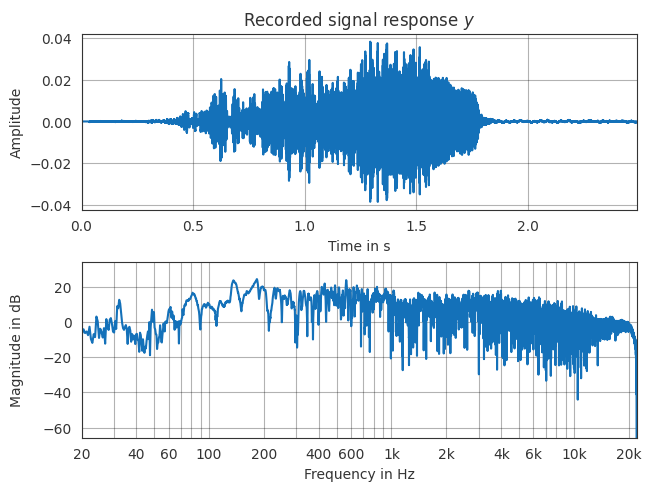

In [7]:
ax = pf.plot.time_freq(y)
ax[0].set_title('Recorded signal response $y$')

Upon first glance the measurement is fine, but it looks as if it was conducted in a rather noisy environment (cf. noise below 50 Hz).

### Computing the Impulse Response

The naive approach to compute the impulse response would be to do an inverse convolution in the time domain. However, it is more efficient and flexible to do a frequency domain deconvolution. Applying the Fourier Transform to the convolution above yields

$$Y[k] = H[k] X[k]$$

with capital letters denoting complex spectra and $k$ the index of the discrete frequency bins. The transfer function (Fourier Transform of the impulse response) can now be computed as

$$H[k] = \frac{Y[k]}{X[k]}\,.$$

While this looks simple, it requires an inversion of the excitation signal and a direct inversion should often be avoided as it will boost out of band noise. This can be seen if plotting the result of the direct inversion $1/H[k]$


Text(0.5, 1.0, 'Direct inversion of the excitation signal')

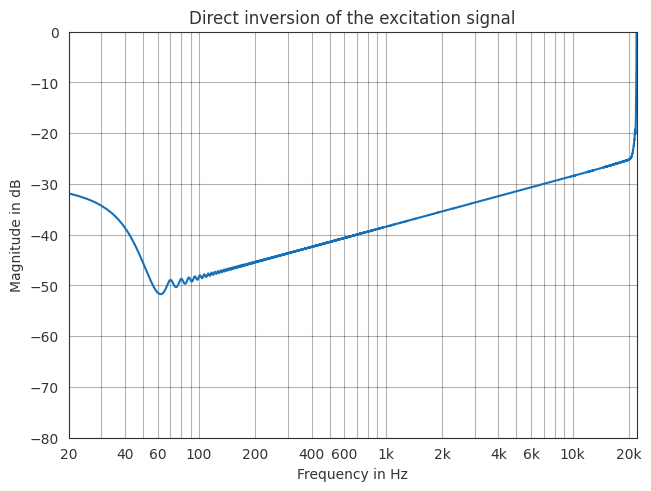

In [8]:
ax = pf.plot.freq(1/x_reference)
ax.set_ylim(-80, 0)
ax.set_title('Direct inversion of the excitation signal')

The solution to this problem is to applied a regularized inversion that limits the inversion effort outside a pre-defined bandwidth. This can be realized with the [`pyfar.dsp`](https://pyfar.readthedocs.io/en/stable/modules/pyfar.dsp.html) module

Text(0.5, 1.0, 'Regularized inversion of the excitation signal')

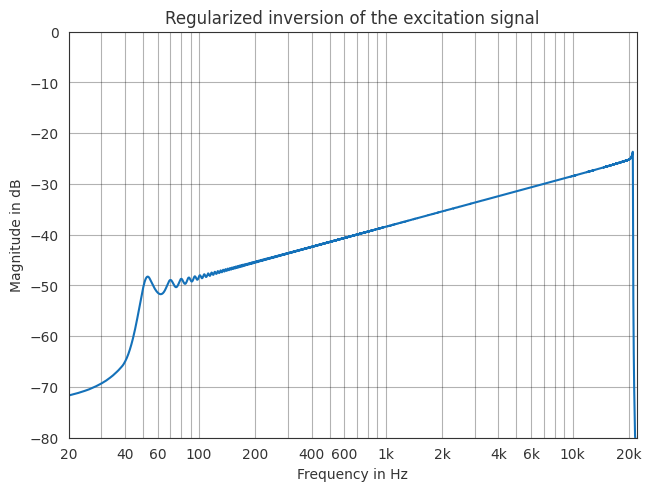

In [9]:
x_inverted = pf.dsp.regularized_spectrum_inversion(x_reference, (55, 21000))

ax = pf.plot.freq(x_inverted)
ax.set_ylim(-80, 0)
ax.set_title('Regularized inversion of the excitation signal')

The transfer function is now computed by a spectral multiplication of the recorded sweep spectrum with the carefully inverted excitation signal

$$H[k]=Y[k]\frac{1}{X[k]}$$

and the impulse response is given by the inverse Fourier Transform

$$h[n]=\mathrm{F}^{-1}\{h[n]\}$$

in pyfar, the frequency domain multiplication is overloaded by the `*` operator and can thus elegantly be realized in a single line

Text(0.5, 1.0, 'Measured impulse response and transfer function')

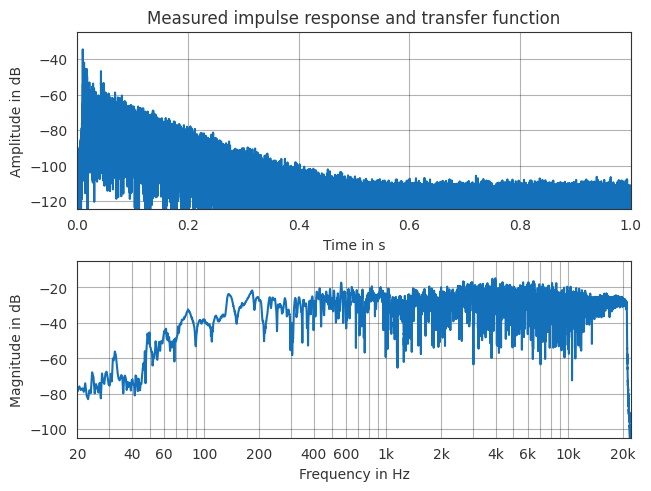

In [10]:
h = y * x_inverted

# plot result
ax = pf.plot.time_freq(h, dB_time=True)
ax[0].set_xlim(0, 1)
ax[0].set_title('Measured impulse response and transfer function')

### Post-processing the impulse response

In many cases, the impulse response will be post-process for example to further reduce out of band noise and shorten the impulse response to its final length. Such tasks can be done with the [`pyfar.dsp`](https://pyfar.readthedocs.io/en/stable/modules/pyfar.dsp.html) module.

In [11]:
# apply high-pass to reject out of band noise
h_processed = pf.dsp.filter.butterworth(h, 8, 40, 'highpass')

# window to reduce impulse response length
h_processed = pf.dsp.time_window(
    h_processed, [0, .01, 0.5, 0.6], unit='s', crop='window')

If applying any post-processing it is always a good idea to check the result with a quick plot

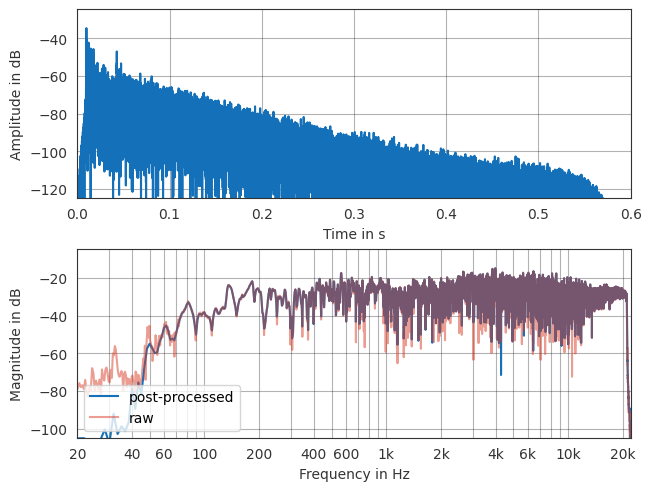

In [12]:
ax = pf.plot.time_freq(h_processed, dB_time=True, label='post-processed')
pf.plot.freq(h, label='raw', ax=ax[1], alpha=.5)
ax[1].legend(loc=3)

### Saving the data

At last, it is always a good idea to save the acquired data. For the purpose of reproducibility and being able to change certain steps of the postprocessing, lets save intermediate results in a compressed file format. pyfar uses its on *far* format, which saves data in zip format.

In [13]:
pf.io.write(
    os.path.join('..', '..', 'resources', 'impulse_response_measurement.far'),
    compressed=True,
    x=x, x_reference=x_reference, y=y)

For the final result, it might be better to save it in a more common format to make sure the result can be imported from different applications.

In [14]:
pf.io.write_audio(
    pf.dsp.normalize(h_processed, target=1-2**(-15)),
    os.path.join('..', '..', 'resources', 'impulse_response_measurement.wav'),
    'DOUBLE')

### Recommended follow up exercises

To get a better feeling for impulse response measurements you can measure your own impulse response and play around with a few things

- What happens if you increase or decrease the level of the sweep during the recording of $y[n]$
- What happens if you use the directly inverted sweep for the deconvolution?
- What happens if the window applied during post-processing is to short?
- What happens if the time shift applied during post-processing is too small or too large?

If you must measure impulse responses there are of course more things that should be considered, for example

- How do I find the optimal output and input level/amplification
- How do I detect problems in the measurement (e.g. clipping, signal drop outs, changing room conditions)
- How can I interact with additional hardware such as turntables?
- What data should I store?
